In [1]:
from dataclasses import dataclass, field
import seaborn as sns
from typing import List
import pathlib
import sys
import os
import tqdm
import multiprocessing
from multiprocessing import Pool
from astropy.visualization import (ImageNormalize, PercentileInterval, PowerStretch)

def get_working_dir():
    """Get the directory of the root of the repository.

    Returns
    -------
    str
        The absolute path to the repository root.
    """
    project_path = pathlib.Path('.').resolve()
    while not (project_path / '.git').exists():
        parent = project_path.parent
        
        if parent == project_path:
            raise RuntimeError('Could not find git root directory')
        
        project_path = parent
    
    return str(project_path)

    
def set_working_dir(project_path):
    sys.path.append(project_path)
    os.chdir(project_path)
    
set_working_dir(get_working_dir())

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import numpy as np
from ipywidgets import interact, widgets

from a2021.a12.a24_3d_to_2d.thylacine.reader import (
    get_time,
    get_coordinates
)

from a2021.a09.a10_read_3d_files.code.data import all_colormaps
from a2022.a06.a23_plots_for_talk.evolution.code.data import data_info, ALL_DATA

from a2022.a06.a23_plots_for_talk.evolution.code.load_data import (
    load_from_data_or_cache,
    load_from_data_or_cache_from_dict,
    variable_names,
    bindata_path,
    min_max_epochs,
    CUSTOM_VARIABLES
)

a2022/a06/a23_plots_for_talk/evolution/code/data.py

In [3]:
def set_plot_style():
    """Set global plotting style"""
    
    # Make images non-blurry on high pixel density screens
    %config InlineBackend.figure_format = 'svg'
    sns.set(style="ticks")

In [4]:
@dataclass
class PlotStyle:
    grid_color: str = "#aaaaaa"
    grid_alpha: float = 0.2


def get_frame_time(epoch, data_name):
    info = data_info(data_name)
      
    data_path = bindata_path(epoch=epoch,
                             data_dir=info['dir'],
                             data_filename=info['file_name'])
    
    return get_time(data_path)


def compare_times(epoch, compare, tolerance):
    time1 = get_frame_time(epoch, compare[0])
    time2 = get_frame_time(epoch, compare[1])
    
    if abs(time1 - time2) > tolerance:
        raise Exception(f"Frame times do not match {time1} != {time2}")


def check_same_times(data_name1, data_name2, tolerance):
    epoch_start1, epoch_end1 = min_max_epochs(data_name=data_name1)
    epoch_start2, epoch_end2 = min_max_epochs(data_name=data_name2)
    min_epoch = min(epoch_end1, epoch_end2)
    
    if epoch_start1 != epoch_start2:
        raise Exception('Different number of snapshots')
        
    for epoch in range(epoch_start1, min_epoch + 1):
        compare_times(epoch, [data_name1, data_name2], tolerance)


def load_all_data(variable, show_gradient, perturbation, compare, cache_files,
                  custom_variables, show_progress, full3d):
    
    return [
        load_from_data_or_cache(
            variable=variable, show_gradient=show_gradient,
            perturbation=perturbation,
            data_name=data_name,
            cache_path=cache_path, custom_variables=custom_variables,
            show_progress=show_progress,
            full3d=full3d)
        for data_name, cache_path in zip(compare, cache_files)
    ]
        
    
def plot_text(ax, text, y):    
    ax.text(
        0.007, y,
        text,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize='large',
        color='#ffffff')
 
 
def logest_axis_index(plots_data): 
    """
    Given the array of `plots_data` return the index with largest time
    dimension
    """
    
    index = 0
    size = 0
    
    for i, data in enumerate(plots_data):
        this_size = data.shape[1]
        
        if this_size > size: 
            size = this_size
            index = i
            
    return index
    
    
def share_x_with_longest_axis(axes, plots_data):
    index = logest_axis_index(plots_data)
    longes_axis = axes[index]
    
    for ax in axes:
        ax.sharex(longes_axis)
    
    
def configure_plots(axes, fig, style, plots_data):       
    for ax in axes:
        ax.invert_yaxis()
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='upper'))
        ax.tick_params(bottom=False, labelbottom=False)
        ax.grid(color=style.grid_color, alpha=style.grid_alpha)
        
    # Keep offset text (i.e. 1e7) only on one plot
    # --------
    
    for ax in axes[1:]:
        ax.yaxis.offsetText.set_alpha(0)
        
    # Show highest axis label for first plot
    axes[0].yaxis.set_major_locator(MaxNLocator(nbins=5))
        
    share_x_with_longest_axis(axes=axes, plots_data=plots_data)

    # Bottom plot
    bot_axis = axes[-1]
    bot_axis.set_xlabel('Time [s]')
    bot_axis.tick_params(bottom=True, labelbottom=True)
    fig.supylabel('Radial position, r [m]', y=0.65)
    
    
def get_space_coordinates(data_name, epoch):
    """
    Return the first and last value for space coordinates in meters
    for each of the x,y,z dimensions.

    Parameters
    ----------
    data_name : str
        Name of the simulation.
        
    epoch : int
        The epoch number.

    Returns
    -------
    dict
        Key: coordinate name, for example 'x', 'y' or 'z'.
        
        Value: array with containing first and last values for the coordinate,
               in meters.
    """
    
    info = data_info(data_name)
    
    data_path = bindata_path(epoch=epoch,
                             data_dir=info['dir'],
                             data_filename=info['file_name'])
    
    coordinates = get_coordinates(data_path)
    
    # Convert coordinates from cm to meters
    return  {
        coordinate: [
            coordinates[coordinate][0] / 100,
            coordinates[coordinate][1] / 100
        ]
        for coordinate in coordinates
    }
    
    
def get_time_range(data_name):
    """
    Return the start and end time in seconds for the simulation.
    """
    
    epoch_start, epoch_end = min_max_epochs(data_name=data_name)
    time_start = get_frame_time(epoch_start, data_name)
    time_end = get_frame_time(epoch_end, data_name)
    
    return [time_start, time_end]
    
    
def make_one_plot(data, ax, data_name, colormap, normalizer):
    time_coordinates = get_time_range(data_name)
    space_coordinates = get_space_coordinates(data_name=data_name, epoch=1)
        
    # Axis limits
    extent = [
        time_coordinates[0], time_coordinates[1], # X
        space_coordinates['x'][1], space_coordinates['x'][0] # Y
    ]
        
    # extent = [0,data.shape[1],1,0]
            
    ax.imshow(data, cmap=colormap, norm=normalizer,
              aspect='auto',
              extent=extent)
    
    title = data_info(data_name)['plot_title']
    plot_text(ax, title, y=0.96)
    

    
def make_image_plots(fig, axes, color_ax, plots_data, colormap, compare,
                     percentile, stretch, max_value):    
    flattened_data = [
        data.flatten()
        for data in plots_data
    ]
    
    # Map data to colors
    combined_data = np.concatenate(flattened_data)
    interval = PercentileInterval(percentile)
    stretch_obj = PowerStretch(stretch)
    normalizer = ImageNormalize(combined_data, interval=interval, stretch=stretch_obj,
                                vmax=max_value)
    

    # Show data
    for data, ax, data_name in zip(plots_data, axes, compare):
        make_one_plot(data=data, ax=ax, data_name=data_name,
                      colormap=colormap,
                      normalizer=normalizer)
    
    # Color bar
    # -----------
    
    ip = InsetPosition(axes[-1], [0.7, -0.24, 0.3, 0.05]) 
    color_ax.set_axes_locator(ip)
    im = cm.ScalarMappable(norm=normalizer, cmap=colormap)
    
    fig.colorbar(im, orientation='horizontal', cax=color_ax,
                 label='Magnitude of mass fraction gradient, $|\\nabla X_1|$')
    
    
def transform_data(variable, data):
    if variable == 'log_kinetic_energy':
        # exclude time zero since it has zero kinetic energy
        return data[:, 1:]
        
    return data

def scale_by_resultion(plots_data):
    '''
    Scale value by pixel size difference. Useful for comparing
    gradients for simulation of different resolutions.
    '''
    
    return [
        scale_by_resultion_one_plot_data(one_plot_data, plots_data[0])
        for one_plot_data in plots_data
    ] 
    
def scale_by_resultion_one_plot_data(data, reference_data):
    '''
    Scale value by pixel size difference. Useful for comparing
    gradients for simulation of different resolutions.
    '''
    
    scale = data.shape[0] / reference_data.shape[0]
    data *= scale
    return data   
    
def make_plots(compare, show_gradient, perturbation,
               style, variable, colormap, cache_files,
               custom_variables, show_progress, percentile,
               stretch, full3d, figsize, max_value):
    
    num_plots = len(compare)
    
    fig, axes = plt.subplots(num_plots + 1, 1,
                             figsize=figsize)
    
    color_ax = axes[-1]
    axes = axes[:-1]
                    
    plots_data = load_all_data(variable=variable,
                               show_gradient=show_gradient,
                               perturbation=perturbation,
                               compare=compare,
                               cache_files=cache_files,
                               custom_variables=custom_variables,
                               show_progress=show_progress,
                               full3d=full3d)
    
    plots_data = [
        transform_data(variable, one_plot_data)
        for one_plot_data in plots_data
    ]
    
    if show_gradient:
        plots_data = scale_by_resultion(plots_data)
    
    make_image_plots(fig=fig, axes=axes,
                     color_ax=color_ax,
                     plots_data=plots_data,
                     colormap=colormap, compare=compare,
                     percentile=percentile, stretch=stretch,
                     max_value=max_value)
    
    configure_plots(axes=axes, fig=fig, style=style, plots_data=plots_data)
    fig.tight_layout(h_pad=-2.55) # Change vertical margin between plots
    return fig, axes
  

def to_filename(name):
    return name.lower().replace(' ', '_')


def get_cache_path(variable, data_name, show_gradient, perturbation, full3d):
    cache_dir = '.cache/2021_11_11/'
    filename = variable    
    if perturbation: show_gradient=True
    if show_gradient: filename = f"{filename}_grad"
    if perturbation: filename = f"{filename}_pert"
    
    info = data_info(data_name)
    
    if info['3d'] and not full3d:
        filename = f"{filename}_2d_slice"
        
    filename = f'{filename}_{to_filename(data_name)}.bin'
    return os.path.join(cache_dir, filename)
      

def get_cache_files(variable, compare, show_gradient, perturbation, full3d):
    return [
        get_cache_path(variable=variable, data_name=data_name,
                       show_gradient=show_gradient, perturbation=perturbation,
                       full3d=full3d)
        
        for data_name in compare
    ] 
    
    
def lets_gooooo(variable, compare, colormap, show_gradient,
                percentile, perturbation, stretch, full3d,
                figsize, max_value):
    set_plot_style()    
    style = PlotStyle()
    if perturbation: show_gradient = True
    
    cache_files = get_cache_files(variable=variable,
                                  compare=compare,
                                  show_gradient=show_gradient,
                                  perturbation=perturbation,
                                  full3d=full3d)
    
    fig, _ = make_plots(compare=compare,
                        show_gradient=show_gradient,
                        perturbation=perturbation,
                        style=style,
                        variable=variable,
                        colormap=colormap,
                        cache_files=cache_files,
                        custom_variables=CUSTOM_VARIABLES,
                        show_progress=True,
                        percentile=percentile,
                        stretch=stretch,
                        full3d=full3d,
                        figsize=figsize,
                        max_value=max_value)    
    
    return fig
    

def get_calculate_params(custom_variables, data_name):
    info = data_info(data_name)
    variables = variable_names(info['dir'], info['file_name'], custom_variables)
    params = []
    
    for variable in variables:
        for show_gradient in [True, False]:            
            for perturbation in [True, False]:
                if perturbation and not show_gradient: continue
            
                for full3d in [True, False]:
                    if not info['3d'] and not full3d: continue
                
                    cache_path = get_cache_path(
                        variable=variable,
                        data_name=data_name,
                        show_gradient=show_gradient,
                        perturbation=perturbation,
                        full3d=full3d)
                    
                    param = {
                        'variable': variable,
                        'show_gradient': show_gradient,
                        'perturbation': perturbation,
                        'data_name': data_name,
                        'cache_path': cache_path,
                        'custom_variables': custom_variables,
                        'show_progress': False,
                        'full3d': full3d
                    }
                    
                    params.append(param)
                        
    return params
                        
    
def calculate_all(custom_variables, data_name):
    params = get_calculate_params(custom_variables, data_name)
    print(f'Calculating {data_name}')
    
    processes = multiprocessing.cpu_count() - 2
    if processes < 1: processes = 1

    with Pool(processes=processes) as p:
        list(tqdm.tqdm(p.imap(load_from_data_or_cache_from_dict, params), total=len(params)))
        
        
def calculate_evolution():
    """Make the data for the evolution plots and save it to cache"""
    check_same_times(data_name1='2D_0.823_percent_lum_0_s',
                     data_name2='3D_1.23345_percent_lum', tolerance=1)

    names = [
        '2D',
        '2D_0.823_percent_lum_0_s',
        '2D_0.823_percent_lum_1032x1032',
        '2D_1_percent_lum_80_s',
        '2D_10_percent_lum_80_s',
        '2D_50_percent_lum_80_s',
        '2D_67_percent_lum_80_s',
        '2D_67_percent_lum_0_s',
        '3D',
        '3D_1.23345_percent_lum',
    ]

    for name in names:
        calculate_all(CUSTOM_VARIABLES, data_name=name)
        
        
# calculate_evolution()

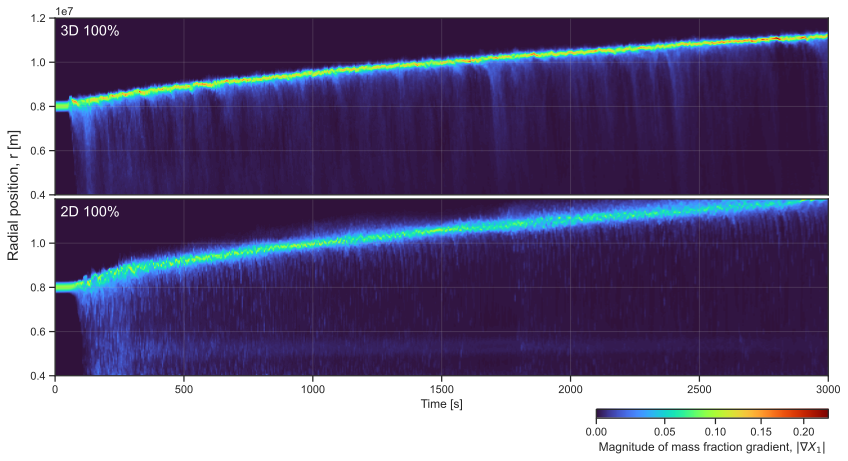

In [8]:
fig = lets_gooooo(variable='0001', show_gradient=True,
                  compare=[
                    #   '2D_0.823_percent_lum_1032x1032',
                    #   '2D_0.823_percent_lum_0_s',
                    #   '3D_1.23345_percent_lum',
                    #   '2D_1_percent_lum_80_s',
                    #   '2D_10_percent_lum_80_s',
                    #   '2D_50_percent_lum_80_s',
                    #   '2D_67_percent_lum_0_s',
                      '3D',
                      '2D',
                  ],
                  colormap='turbo',
                  percentile=100,
                  perturbation=False,
                  stretch=0.8,
                  full3d=False,
                  figsize=(12, 8),
                  max_value=0.23)

os.makedirs('plots_tmp/talk/', exist_ok=True)

fig.savefig('plots_tmp/talk/evolution_2d_3d.png', bbox_inches='tight', dpi=300,
            pad_inches=0.1)

plt.show(fig)